In [ ]:
# ✅ Step 1: Install Java and Spark (updated)
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

# Download Spark 3.4.1 from a working Apache mirror
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz

# Extract it
!tar -xvzf spark-3.4.1-bin-hadoop3.tgz

# Install findspark
!pip install -q findspark


spark-3.4.1-bin-hadoop3/
spark-3.4.1-bin-hadoop3/R/
spark-3.4.1-bin-hadoop3/R/lib/
spark-3.4.1-bin-hadoop3/R/lib/sparkr.zip
spark-3.4.1-bin-hadoop3/R/lib/SparkR/
spark-3.4.1-bin-hadoop3/R/lib/SparkR/html/
spark-3.4.1-bin-hadoop3/R/lib/SparkR/html/R.css
spark-3.4.1-bin-hadoop3/R/lib/SparkR/html/00Index.html
spark-3.4.1-bin-hadoop3/R/lib/SparkR/INDEX
spark-3.4.1-bin-hadoop3/R/lib/SparkR/help/
spark-3.4.1-bin-hadoop3/R/lib/SparkR/help/aliases.rds
spark-3.4.1-bin-hadoop3/R/lib/SparkR/help/AnIndex
spark-3.4.1-bin-hadoop3/R/lib/SparkR/help/SparkR.rdx
spark-3.4.1-bin-hadoop3/R/lib/SparkR/help/SparkR.rdb
spark-3.4.1-bin-hadoop3/R/lib/SparkR/help/paths.rds
spark-3.4.1-bin-hadoop3/R/lib/SparkR/worker/
spark-3.4.1-bin-hadoop3/R/lib/SparkR/worker/worker.R
spark-3.4.1-bin-hadoop3/R/lib/SparkR/worker/daemon.R
spark-3.4.1-bin-hadoop3/R/lib/SparkR/tests/
spark-3.4.1-bin-hadoop3/R/lib/SparkR/tests/testthat/
spark-3.4.1-bin-hadoop3/R/lib/SparkR/tests/testthat/test_basic.R
spark-3.4.1-bin-hadoop3/R/lib/S

In [ ]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("NYC Taxi Trip Analysis") \
    .getOrCreate()

spark


In [3]:
trip_df = spark.read.csv("/content/yellow_tripdata_2015-01.csv", header=True, inferSchema=True)
trip_df.printSchema()
trip_df.show(5)


root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- RateCodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+------------------+---------------

In [4]:
# Drop rows with missing or invalid values
trip_df_clean = trip_df.dropna()

# Filter for valid trips only
trip_df_clean = trip_df_clean.filter(
    (trip_df_clean.passenger_count > 0) &
    (trip_df_clean.trip_distance > 0) &
    (trip_df_clean.fare_amount > 0)
)

In [5]:
print("🚕 Total clean trips:")
print(trip_df_clean.count())

print("💰 Average fare amount:")
trip_df_clean.selectExpr("avg(fare_amount) as average_fare").show()

print("📏 Average trip distance:")
trip_df_clean.selectExpr("avg(trip_distance) as average_distance").show()

🚕 Total clean trips:
347455
💰 Average fare amount:
+------------------+
|      average_fare|
+------------------+
|11.840018477212782|
+------------------+

📏 Average trip distance:
+-----------------+
| average_distance|
+-----------------+
|3.143762213811859|
+-----------------+



In [8]:
from pyspark.sql.functions import unix_timestamp, col

trip_df_clean = trip_df_clean.withColumn("trip_duration",
    (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 60
)
print("⏱️ Average trip duration (minutes):")
trip_df_clean.selectExpr("avg(trip_duration) as avg_trip_duration_minutes").show()

print("📍 Top 10 pickup locations by trip count:")
trip_df_clean.groupBy("pickup_longitude", "pickup_latitude") \
    .count().orderBy("count", ascending=False).show(10)

print("🧍 Trips by passenger count:")
trip_df_clean.groupBy("passenger_count").count().orderBy("passenger_count").show()

⏱️ Average trip duration (minutes):
+-------------------------+
|avg_trip_duration_minutes|
+-------------------------+
|       13.104117511620219|
+-------------------------+

📍 Top 10 pickup locations by trip count:
+------------------+------------------+-----+
|  pickup_longitude|   pickup_latitude|count|
+------------------+------------------+-----+
|               0.0|               0.0| 6177|
|-73.94863891601562| 40.74489974975586|   24|
| -74.1863021850586| 40.69314193725586|   20|
|-74.00314331054688| 40.72767639160156|    9|
|-73.91512298583984| 40.74357604980469|    9|
|-73.92151641845703|40.691463470458984|    6|
|-73.99085235595703| 40.76088333129883|    5|
| -73.9867172241211|  40.7222900390625|    5|
|-73.87083435058594|40.773738861083984|    5|
|-73.91619873046875| 40.77996826171875|    4|
+------------------+------------------+-----+
only showing top 10 rows

🧍 Trips by passenger count:
+---------------+------+
|passenger_count| count|
+---------------+------+
|        

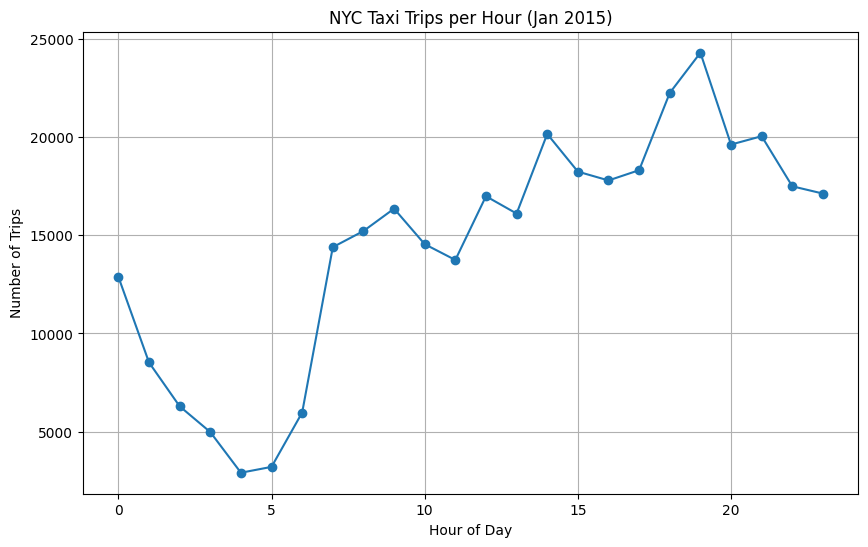

In [10]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import hour

trip_df_clean = trip_df_clean.withColumn("pickup_hour", hour("tpep_pickup_datetime"))

hourly_df = trip_df_clean.groupBy("pickup_hour").count().orderBy("pickup_hour").toPandas()
plt.figure(figsize=(10,6))
plt.plot(hourly_df["pickup_hour"], hourly_df["count"], marker='o')
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.title("NYC Taxi Trips per Hour (Jan 2015)")
plt.grid(True)
plt.show()

In [11]:
print("\n📊 FINAL SUMMARY:")
print(f"✅ Total clean trips: {trip_df_clean.count()}")
trip_df_clean.selectExpr(
    "avg(fare_amount) as avg_fare",
    "avg(trip_distance) as avg_distance",
    "avg(trip_duration) as avg_duration_minutes"
).show()


📊 FINAL SUMMARY:
✅ Total clean trips: 347455
+------------------+-----------------+--------------------+
|          avg_fare|     avg_distance|avg_duration_minutes|
+------------------+-----------------+--------------------+
|11.840018477212782|3.143762213811859|  13.104117511620219|
+------------------+-----------------+--------------------+

